In [14]:
#Import required libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from warnings import filterwarnings
filterwarnings('ignore')

In [39]:
from sklearn.cluster import KMeans
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

In [2]:
#read the excel sheet as dataframe

sprocket_central = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')

df_transactions = pd.read_excel(sprocket_central, 'Transactions', header=1)

df_newcustomers = pd.read_excel(sprocket_central, 'NewCustomerList', header=1)

df_demographic = pd.read_excel(sprocket_central, 'CustomerDemographic', header=1)

df_address = pd.read_excel(sprocket_central, 'CustomerAddress', header=1)


In [20]:
#drop insignificant variable
df_demographic.drop(['first_name', 'last_name', 'default', 'job_title'], axis=1, inplace=True)

In [21]:
df_demographic.drop('deceased_indicator', axis=1, inplace=True)

In [22]:
#Some variables are encoded with 2 names for single category

df_demographic['gender'].replace(['F', 'Femal'], 'Female', inplace=True)
df_demographic['gender'].replace('M', 'Male', inplace=True)
df_demographic['gender'].replace('U', 'Unknown', inplace=True)

In [23]:
#Drop null
df_demographic = df_demographic.dropna()

In [25]:
#creating age column
df_demographic['age'] = (dt.datetime.now() - df_demographic['DOB']) / np.timedelta64(1, 'Y')
df_demographic['age_class'] = ((round(df_demographic['age'] / 10)) * 10).astype(int)
df_demographic.head()

,customer_id,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class
0,1,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,67.609917,70
1,2,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,40.430714,40
2,3,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0,67.336127,70
3,4,Male,33,1961-10-03,IT,Mass Customer,No,7.0,59.634394,60
5,6,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,54.681520,50


In [19]:
df_address = df_address.dropna()

df_address['state'].replace('New South Wales', 'NSW', inplace=True)
df_address['state'].replace('Victoria', 'VIC', inplace=True)

In [26]:
df_demo_add = pd.merge(df_demographic, df_address, left_index=True, right_index=True)
df_demo_add= df_demo_add.dropna()
df_demo_add.head()

,customer_id_x,gender,past_3_years_bike_related_purchases,DOB,job_industry_category,wealth_segment,owns_car,tenure,age,age_class,customer_id_y,address,postcode,state,country,property_valuation
0,1,Female,93,1953-10-12,Health,Mass Customer,Yes,11.0,67.609917,70,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,Male,81,1980-12-16,Financial Services,Mass Customer,Yes,16.0,40.430714,40,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,3,Male,61,1954-01-20,Property,Mass Customer,Yes,15.0,67.336127,70,4,0 Holy Cross Court,4211,QLD,Australia,9
3,4,Male,33,1961-10-03,IT,Mass Customer,No,7.0,59.634394,60,5,17979 Del Mar Point,2448,NSW,Australia,4
5,6,Male,35,1966-09-16,Retail,High Net Worth,Yes,13.0,54.681520,50,7,4 Delaware Trail,2210,NSW,Australia,9


In [28]:
df_transactions = df_transactions.sort_values('customer_id')

In [30]:
df_transactions = df_transactions.dropna()

In [31]:
df_transactions['product_first_sold_date'] = pd.TimedeltaIndex(df_transactions['product_first_sold_date'], unit='d') + dt.datetime(1900,1,1)
df_transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
14485,14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,1991-08-07
18969,18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,1996-11-11
16422,16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,2003-08-07
5156,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-23
13423,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-11


In [32]:
df_transactions['transaction_date'].describe(datetime_is_numeric=True)

count                            19445
mean     2017-07-01 16:21:18.189773824
min                2017-01-01 00:00:00
25%                2017-04-01 00:00:00
50%                2017-07-03 00:00:00
75%                2017-10-02 00:00:00
max                2017-12-30 00:00:00
Name: transaction_date, dtype: object

In [33]:
most_recent_purchase = df_transactions['transaction_date'].max()
df_transactions['last_purchase_days_ago'] = most_recent_purchase - df_transactions['transaction_date']
df_transactions['last_purchase_days_ago'] /= np.timedelta64(1, 'D')
df_transactions['profit'] = df_transactions['list_price'] - df_transactions['standard_cost']
df_transactions.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,last_purchase_days_ago,profit
14485,14486,23,1,2017-03-27,0.0,Approved,Norco Bicycles,Mountain,low,small,688.63,612.88,1991-08-07,278.0,75.75
18969,18970,11,1,2017-03-29,1.0,Approved,Giant Bicycles,Standard,high,medium,1274.93,764.96,1996-11-11,276.0,509.97
16422,16423,9,1,2017-12-09,1.0,Approved,OHM Cycles,Road,medium,medium,742.54,667.40,2003-08-07,21.0,75.14
5156,5157,47,1,2017-05-11,1.0,Approved,Trek Bicycles,Road,low,small,1720.70,1531.42,2003-07-23,233.0,189.28
13423,13424,2,1,2017-02-21,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,2005-08-11,312.0,17.87


In [50]:
customer_data = df_transactions.groupby('customer_id').agg({
    'customer_id' : lambda x:x,
    'last_purchase_days_ago': lambda x: x.min(),
    'customer_id': lambda x: len(x),
    'profit': lambda x: x.sum()
})


In [51]:

customer_data.rename(columns={
    'last_purchase_days_ago': 'recency', 
    'customer_id': 'frequency', 
    'profit': 'monetary_value'
    }, inplace=True)

In [52]:
customer_data.head()

,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.09
2,3,128.0,2226.26
3,7,102.0,3290.21
4,2,195.0,220.57
5,6,16.0,2394.94


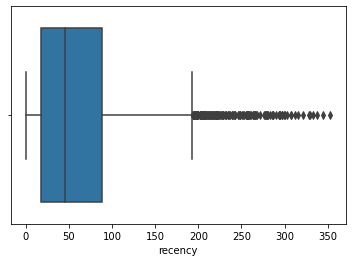

In [53]:
# outlier treatment for recency
sns.boxplot(customer_data['recency'])

q1 = customer_data.recency.quantile(0.25)
q3 = customer_data.recency.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.recency >= q1 - 1.5*iqr) & (customer_data.recency <= q3 + 1.5*iqr)]

,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.090000
2,3,128.0,2226.260000
3,7,102.0,3290.210000
5,6,16.0,2394.940000
6,5,64.0,3946.550000
...,...,...,...
3497,3,52.0,1648.320000
3498,6,127.0,3147.330000
3499,7,51.0,4955.250000


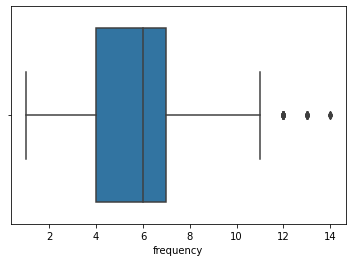

In [54]:
# outlier treatment for frequency

sns.boxplot(customer_data['frequency'])

q1 = customer_data.frequency.quantile(0.25)
q3 = customer_data.frequency.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.frequency >= q1 - 1.5*iqr) & (customer_data.frequency <= q3 + 1.5*iqr)]

customer_data

In [56]:
# outlier treatment for monetary
q1 = customer_data.monetary_value.quantile(0.25)
q3 = customer_data.monetary_value.quantile(0.75)
iqr = q3 - q1
customer_data = customer_data[(customer_data.monetary_value >= q1 - 1.5*iqr) & (customer_data.monetary_value <= q3 + 1.5*iqr)]

customer_data

,frequency,recency,monetary_value
customer_id,,,
1,11,7.0,3018.090000
2,3,128.0,2226.260000
3,7,102.0,3290.210000
5,6,16.0,2394.940000
6,5,64.0,3946.550000
...,...,...,...
3497,3,52.0,1648.320000
3498,6,127.0,3147.330000
3499,7,51.0,4955.250000


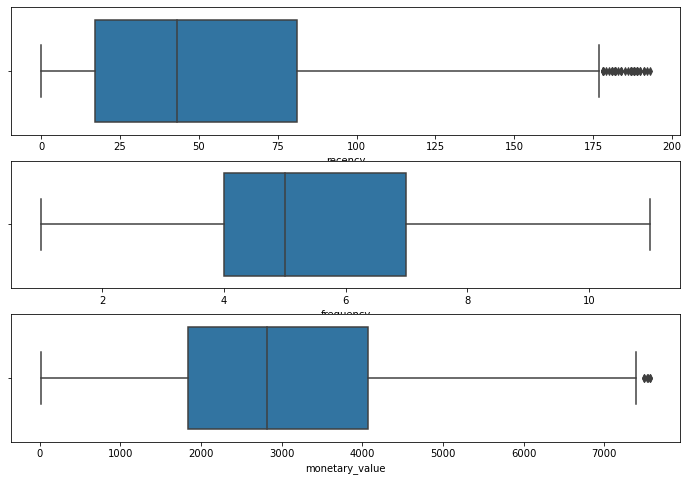

In [62]:
fig, ax = plt.subplots(3, 1, figsize=(12,8))

sns.boxplot(customer_data['recency'], ax= ax[0] )
sns.boxplot(customer_data['frequency'], ax=ax[1] )
sns.boxplot(customer_data['monetary_value'], ax=ax[2])
plt.show()

In [63]:
#standardise the data set

ss = StandardScaler()

customer_data['recency'] = ss.fit_transform(customer_data[['recency']] )

customer_data['frequency'] = ss.fit_transform(customer_data[['frequency']] )

customer_data['monetary_value'] = ss.fit_transform(customer_data[['monetary_value']] )

In [65]:
RFM = customer_data.copy()
RFM

,frequency,recency,monetary_value
customer_id,,,
1,2.567054,-1.043368,-0.004556
2,-1.214537,1.586116,-0.506816
3,0.676258,1.021103,0.168050
5,0.203559,-0.847786,-0.399822
6,-0.269139,0.195315,0.584368
...,...,...,...
3497,-1.214537,-0.065461,-0.873404
3498,0.203559,1.564384,0.077421
3499,0.676258,-0.087192,1.224189


In [66]:
# create elbow curve and find optimal number of clusters
cluster_error = []

for num_clusters in range(1,15):
    clusters = KMeans(n_clusters=num_clusters, n_init=10)
    clusters.fit(RFM)
    cluster_error.append(clusters.inertia_)
    labels = clusters.labels_
    centroid = clusters.cluster_centers_

clusters_df = pd.DataFrame({'num_of_clusters': (range(1,15)), 'Cluster_errors' : cluster_error})
clusters_df

,num_of_clusters,Cluster_errors
0,1,9774.000000
1,2,5838.468515
2,3,4122.278671
3,4,3412.608015
4,5,2893.224752
5,6,2628.098145
6,7,2388.582975
7,8,2164.014728
8,9,1997.354075
9,10,1854.129582


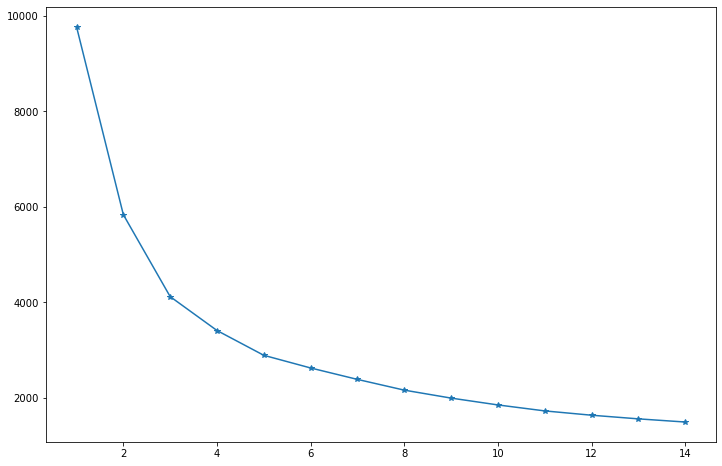

In [67]:
plt.figure(figsize=(12,8))
plt.plot(clusters_df['num_of_clusters'], clusters_df['Cluster_errors'], marker='*')

#optimal number of clusters = 3

In [68]:
#create clusters using Kmean clustering

model = KMeans(n_clusters=3, n_init=15, random_state=2345)
model.fit(RFM)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [69]:
centroids = model.cluster_centers_
centroids

array([[-0.71324762,  1.45967131, -0.59248744],
       [-0.46253231, -0.50123998, -0.53940942],
       [ 0.97626332, -0.35330297,  0.98725663]])

In [70]:
model.labels_

array([2, 0, 2, ..., 2, 0, 0])

In [71]:
RFM['lables'] = model.labels_

In [72]:
RFM

,frequency,recency,monetary_value,lables
customer_id,,,,
1,2.567054,-1.043368,-0.004556,2
2,-1.214537,1.586116,-0.506816,0
3,0.676258,1.021103,0.168050,2
5,0.203559,-0.847786,-0.399822,1
6,-0.269139,0.195315,0.584368,1
...,...,...,...,...
3497,-1.214537,-0.065461,-0.873404,1
3498,0.203559,1.564384,0.077421,0
3499,0.676258,-0.087192,1.224189,2


In [76]:
#mean for recency, frequency, monetary

print(RFM.recency.mean())
print(RFM.frequency.mean())
print(RFM.monetary_value.mean())

4.429987513851147e-19
4.573110187375568e-17
2.2224906588720907e-16


<AxesSubplot:>

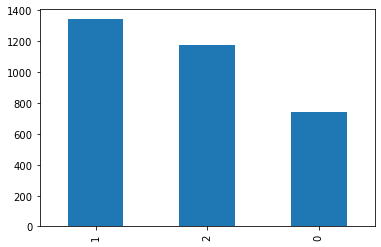

In [74]:
#create bar plots

(RFM.lables.value_counts()).plot(kind='bar')

<AxesSubplot:xlabel='lables', ylabel='count'>

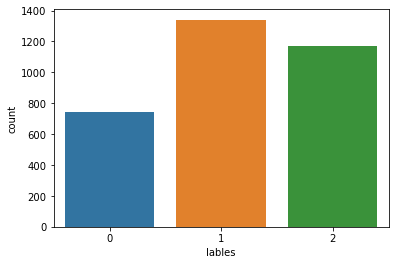

In [75]:
sns.countplot(RFM['lables'])

In [77]:
#Based on the labels, we can analyse for each type of customers

# ************Thank You************